In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch.utils.data import DataLoader

from data.scannet.utils_scannet_fast import ScanNetDataset
from DEPO.depo import depo_v2, depo_v3, depo_v4, depo_v6, depo_v7, depo_v8, depo_v13, depo_best
from DEPO.depo_ablations import A5

from training.train_depo_pose import test as test_pose
from training.train_depo_pose_and_flow import test as test_pose_and_flow

from utils.model import load_checkpoint, count_parameters
from utils.metrics import mAA, rotation_angle_distance_batch, vector_angle_distance_batch, mAA_max, mAA_sep

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd 

from tqdm.auto import tqdm
import pickle
from pathlib import Path
import time

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 0. Data

In [6]:
test_data = ScanNetDataset(
    root_dir='/home/project/ScanNet/scannet_test_1500/',
    npz_path='/home/project/ScanNet/test.npz',
    intrinsics_path='/home/project/ScanNet/intrinsics_test.npz',
    calculate_flow=True
)

test_loader = DataLoader(test_data, batch_size=4, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

## 1. Metrics

In [7]:
metrics = {}

if Path('/home/project/code/results/scannet/metrics_depo').is_file():
    with open('/home/project/code/results/scannet/metrics_depo', 'rb') as f:
        metrics = pickle.load(f)

### 1. DEPO-A: PCPVT-L + QT-B + Spatial. pred. 

In [26]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_to_pose_v2_8.pth',
    device)

In [27]:
model = depo_v2()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [42]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 9.73m of paraeters in total:
________________________________________
self-encoder: 5.81m
cross-encoder: 0.07m
pose regressor: 1.88m


In [13]:
results = test_pose_and_flow(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:08<00:00,  1.51it/s]


In [17]:
name = "DEPO-A: PCPVT-L + QT-B + Spatial pred."
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [18]:
name = "DEPO-A: PCPVT-L + QT-B + Spatial pred."
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0223
mAA 10 rotation      0.1120
mAA 20 rotation      0.3018


### 2. DEPO-B: PCPVT-L + QT-B + Spatial. pred. 

In [43]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/pose_v6_9.pth',
    device)

In [44]:
model = depo_v6()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [45]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 13.39m of paraeters in total:
________________________________________
self-encoder: 5.81m
cross-encoder: 0.07m
pose regressor: 6.08m


In [21]:
results = test_pose(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:05<00:00,  1.53it/s]


In [22]:
name = "DEPO-B: PCPVT-L + QT-B + Spatial pred."
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [23]:
name = "DEPO-B: PCPVT-L + QT-B + Spatial pred."
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0242
mAA 10 rotation      0.1395
mAA 20 rotation      0.3435


### 3. DEPO-C: PCPVT-L + QT-B + Spatial. pred. 

In [46]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_and_pose_v3_4_5.pth',
    device)

In [47]:
model = depo_v3()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [51]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'intrinsics-mlp: {count_parameters(model.intrinsics_mlp):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'geometry-decoder: {count_parameters(model.geometry_decoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 13.58m of paraeters in total:
________________________________________
self-encoder: 5.81m
intrinsics-mlp: 0.10m
cross-encoder: 0.07m
geometry-decoder: 1.31m
pose regressor: 5.63m


In [26]:
results = test_pose_and_flow(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:05<00:00,  1.52it/s]


In [27]:
name = "DEPO-C: PCPVT-L + QT-B + Spatial pred."
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [28]:
name = "DEPO-C: PCPVT-L + QT-B + Spatial. pred."
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0565
mAA 10 rotation      0.2258
mAA 20 rotation      0.4624


### 4. DEPO-C: PVT-L + QT-B + Spatial. pred. 

In [52]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_and_pose_v4_9.pth',
    device)

In [53]:
model = depo_v4()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [54]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'intrinsics-mlp: {count_parameters(model.intrinsics_mlp):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'geometry-decoder: {count_parameters(model.geometry_decoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 12.76m of paraeters in total:
________________________________________
self-encoder: 4.22m
intrinsics-mlp: 0.10m
cross-encoder: 0.26m
geometry-decoder: 1.61m
pose regressor: 5.63m


In [32]:
results = test_pose_and_flow(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:06<00:00,  1.52it/s]


In [33]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred."
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [34]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred."
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0588
mAA 10 rotation      0.2075
mAA 20 rotation      0.4310


### 5. DEPO-C: PVT-L + QT-B + Spatial. pred. (after ablations) 

In [7]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/depo_with_modifications_9.pth',
    device)

In [8]:
model = A5()
model.load_state_dict(checkpoint['model'])
model.to(device);

In [57]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'intrinsics-mlp: {count_parameters(model.intrinsics_mlp):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'geometry-decoder: {count_parameters(model.geometry_decoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 12.89m of paraeters in total:
________________________________________
self-encoder: 4.22m
intrinsics-mlp: 0.10m
cross-encoder: 0.26m
geometry-decoder: 1.61m
pose regressor: 5.63m


In [9]:
results = test_pose_and_flow(model, test_loader, device)

  0%|          | 0/375 [00:00<?, ?it/s]

In [10]:
np.savez('results.npz', **results)

In [11]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations)"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [12]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations)"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.1256
mAA 10 rotation      0.3466
mAA 20 rotation      0.5733


### 6. LaDEPO-C: PVT-L + QT-B + latent

In [48]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/ladepo_flow_and_pose_9.pth',
    device)

In [49]:
model = depo_v7(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [50]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'intrinsics-mlp: {count_parameters(model.intrinsics_mlp):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'geometry-decoder: {count_parameters(model.geometry_decoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 31.37m of paraeters in total:
________________________________________
self-encoder: 4.22m
intrinsics-mlp: 0.40m
cross-encoder: 0.26m
geometry-decoder: 1.64m
pose regressor: 23.21m


In [10]:
results = test_pose_and_flow(model, test_loader, device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:21<00:00,  7.46it/s]


In [12]:
name = "LaDEPO-C: PVT-L + QT-B + latent"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [13]:
name = "LaDEPO-C: PVT-L + QT-B + latent"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0917
mAA 10 rotation      0.3008
mAA 20 rotation      0.5434


### Speed computation

In [53]:
time_eval = []
N=0
model.eval()
with torch.no_grad():
    while N < 101:
        N+=1
        data = next(iter(test_loader))
        for key in data.keys():
            if key in ('image_0', 'image_1', 'K_0', 'K_1', 'flow_0to1', 'mask'):
                data[key] = data[key].to(device)   
        B = data['image_0'].size(0)

        start = time.time() * 1000
        flow, q, t = model(
            img_q=data['image_0'], img_s=data['image_1'],
            K_q=data['K_0'], K_s=data['K_1'],
            scales_q=0.125 * torch.ones((B, 2), device=device),
            scales_s=0.125 * torch.ones((B, 2), device=device),
            H=60, W=80)
        end = time.time() * 1000
        time_eval.append(end-start)

    time_eval = np.array(time_eval)
    print(f'Running time is {np.mean(time_eval)} ms $\pm$ {np.std(time_eval)} ms')

Running time is 23.716632503094058 ms $\pm$ 0.1916254425588172 ms


### 7. DEPO-C: PVT-L + QT-B + Spatial pred. (relative)

In [8]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_and_pose_best_relative_2.pth',
    device)

In [9]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [10]:
print(f'Model has {count_parameters(model):.2f}m of paraeters in total:')
print('_' * 40)
print(f'self-encoder: {count_parameters(model.self_encoder):.2f}m')
print(f'intrinsics-mlp: {count_parameters(model.intrinsics_mlp):.2f}m')
print(f'cross-encoder: {count_parameters(model.cross_encoder):.2f}m')
print(f'geometry-decoder: {count_parameters(model.geometry_decoder):.2f}m')
print(f'pose regressor: {count_parameters(model.pose_regressor):.2f}m')

Model has 12.89m of paraeters in total:
________________________________________
self-encoder: 4.22m
intrinsics-mlp: 0.10m
cross-encoder: 0.26m
geometry-decoder: 1.61m
pose regressor: 5.63m


In [12]:
results = test_pose_and_flow(model, test_loader, device)

In [12]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred. (relative)"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [13]:
name = "DEPO-C: PVT-L + QT-B + Spatial pred. (relative)"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0000
mAA 10 rotation      0.0007
mAA 20 rotation      0.0076


### 8. DEPO-C: PVT-L + QT-B + Spatial pred. (absolute)

In [8]:
checkpoint = load_checkpoint(
    '/home/project/code/src/weights/flow_and_pose_best_abs_0.pth',
    device)

In [9]:
model = depo_best(calculate_flow=False)
model.load_state_dict(checkpoint['model'])
model.to(device);

In [10]:
results = test_pose_and_flow(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [02:12<00:00,  2.84it/s]


In [11]:
name = "DEPO-C-f: PVT-L + QT-B + Spatial pred. (absolute)"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [12]:
name = "DEPO-C-f: PVT-L + QT-B + Spatial pred. (absolute)"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.2227
mAA 10 rotation      0.4940
mAA 20 rotation      0.6979


In [19]:
np.savez('results.npz', **results)

### Speed computation

In [45]:
time_eval = []
N=0
model.eval()
with torch.no_grad():
    while N < 101:
        N+=1
        data = next(iter(test_loader))
        for key in data.keys():
            if key in ('image_0', 'image_1', 'K_0', 'K_1', 'flow_0to1', 'mask'):
                data[key] = data[key].to(device)   
        B = data['image_0'].size(0)

        start = time.time() * 1000
        flow, q, t = model(
            img_q=data['image_0'], img_s=data['image_1'],
            K_q=data['K_0'], K_s=data['K_1'],
            scales_q=0.125 * torch.ones((B, 2), device=device),
            scales_s=0.125 * torch.ones((B, 2), device=device),
            H=60, W=80)
        end = time.time() * 1000
        time_eval.append(end-start)

    time_eval = np.array(time_eval)
    print(f'Running time is {np.mean(time_eval)} ms $\pm$ {np.std(time_eval)} ms')

Running time is 18.419448097153467 ms $\pm$ 0.26127333797487184 ms


#### Saving metrics

In [13]:
with open('/home/project/code/results/scannet/metrics_depo', 'wb') as f:
    pickle.dump(metrics, f)

# 2. Results
### 2.1 Table form


In [14]:
df = pd.DataFrame(index=metrics.keys())

for q in (0.25, 0.5, 0.75, 0.9):
    df[f'R_q={q}'] = None
    df[f't_q={q}'] = None
    df[f'angle_t_q={q}'] = None
    for key, val in metrics.items():
        df.loc[key, f't_q={q}'] = np.quantile(val["t_distances_l2"], q)
        df.loc[key, f'R_q={q}'] = np.quantile(val["R_angle_distances"], q)
        df.loc[key, f'angle_t_q={q}'] = np.quantile(val["t_angle_distances"], q)
        d = df.style.format(precision=2)
df.sort_index(axis=1, inplace=True)


for col in df.columns:
    d.background_gradient(cmap="RdYlGn_r", subset=col)
d

,R_q=0.25,R_q=0.5,R_q=0.75,R_q=0.9,angle_t_q=0.25,angle_t_q=0.5,angle_t_q=0.75,angle_t_q=0.9,t_q=0.25,t_q=0.5,t_q=0.75,t_q=0.9
DEPO-A: PCPVT-L + QT-B + Spatial. pred.,7.18,13.70,27.76,57.63,36.93,64.14,100.29,134.73,0.27,0.57,1.11,1.96
DEPO-B: PCPVT-L + QT-B + Spatial. pred.,6.45,12.29,25.68,55.30,28.85,50.66,82.64,118.23,0.24,0.50,0.99,1.84
DEPO-C: PCPVT-L + QT-B + Spatial. pred.,4.65,8.11,16.08,44.58,18.87,37.98,66.28,99.36,0.20,0.42,0.87,1.76
DEPO-C: PVT-L + QT-B + Spatial. pred.,5.09,9.40,19.79,42.60,19.33,36.95,64.09,98.71,0.20,0.42,0.85,1.70
DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations),3.19,5.90,11.46,26.58,11.80,22.18,40.77,70.11,0.15,0.30,0.61,1.24
LaDEPO-C: PVT-L + QT-B + latent,3.59,6.38,12.02,29.74,14.02,27.52,53.91,84.27,0.16,0.33,0.71,1.52
DEPO-C: PVT-L + QT-B + Spatial pred. (relative),2.38,4.21,8.51,17.44,8.58,16.43,30.10,53.68,2.98,4.62,6.60,8.41
DEPO-C-f: PVT-L + QT-B + Spatial pred. (absolute),2.03,3.59,6.69,13.45,7.73,15.48,28.33,52.61,0.11,0.21,0.43,1.01


In [15]:
df = pd.DataFrame(index=metrics.keys())

for t in (5, 10, 20, 30):
    df[f'mAA_R_{t}'] = None
    df[f'mAA_t_{t}'] = None
    df[f'mAA_max_{t}'] = None
    for key, val in metrics.items():
        df.loc[key, f'mAA_R_{t}'] = mAA_sep(val["R_angle_distances"], t, 10000)
        df.loc[key, f'mAA_t_{t}'] = mAA_sep(val["t_angle_distances"], t, 10000)
        df.loc[key, f'mAA_max_{t}'] = mAA_max(val["R_angle_distances"], val["t_angle_distances"], t, 100)
        d = df.style.format(precision=2)
df.sort_index(axis=1, inplace=True)
df.sort_index(axis=0, inplace=True)

for col in df.columns:
    d.background_gradient(cmap="RdYlGn", subset=col)
d

,mAA_R_10,mAA_R_20,mAA_R_30,mAA_R_5,mAA_max_10,mAA_max_20,mAA_max_30,mAA_max_5,mAA_t_10,mAA_t_20,mAA_t_30,mAA_t_5
DEPO-A: PCPVT-L + QT-B + Spatial. pred.,0.15,0.34,0.47,0.04,0.00,0.02,0.04,0.00,0.01,0.03,0.07,0.00
DEPO-B: PCPVT-L + QT-B + Spatial. pred.,0.18,0.37,0.49,0.05,0.01,0.04,0.08,0.00,0.02,0.06,0.11,0.00
DEPO-C-f: PVT-L + QT-B + Spatial pred. (absolute),0.55,0.72,0.80,0.32,0.12,0.29,0.42,0.03,0.14,0.31,0.44,0.05
DEPO-C: PCPVT-L + QT-B + Spatial. pred.,0.28,0.50,0.61,0.10,0.02,0.08,0.15,0.00,0.04,0.12,0.19,0.01
DEPO-C: PVT-L + QT-B + Spatial pred. (after ablations),0.39,0.60,0.70,0.18,0.05,0.17,0.29,0.01,0.08,0.20,0.32,0.03
DEPO-C: PVT-L + QT-B + Spatial pred. (relative),0.49,0.68,0.76,0.27,0.10,0.26,0.39,0.02,0.12,0.29,0.42,0.04
DEPO-C: PVT-L + QT-B + Spatial. pred.,0.24,0.45,0.57,0.09,0.02,0.08,0.15,0.00,0.04,0.11,0.19,0.01
LaDEPO-C: PVT-L + QT-B + latent,0.36,0.58,0.68,0.16,0.04,0.14,0.24,0.01,0.06,0.16,0.26,0.02


### 2.2 Plots

In [16]:
plt.style.use('default')

rc('text', usetex=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

rc('font', size=MEDIUM_SIZE)          # controls default text sizes
rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [17]:
def calculate_metric_on_subset(metric_values, values_dependent_on, agg_func, thresholds, sign):
    thresholds_ = thresholds[:, None]
    if sign == '>':
        inliers_bool = values_dependent_on > thresholds_
    else:
        inliers_bool = values_dependent_on <= thresholds_
    scores = np.array([agg_func(metric_values[subset]) for subset in inliers_bool])
    return scores

FileNotFoundError: [Errno 2] No such file or directory: '/home/project/code/results/images/scannet_cdfs_depo.pdf'

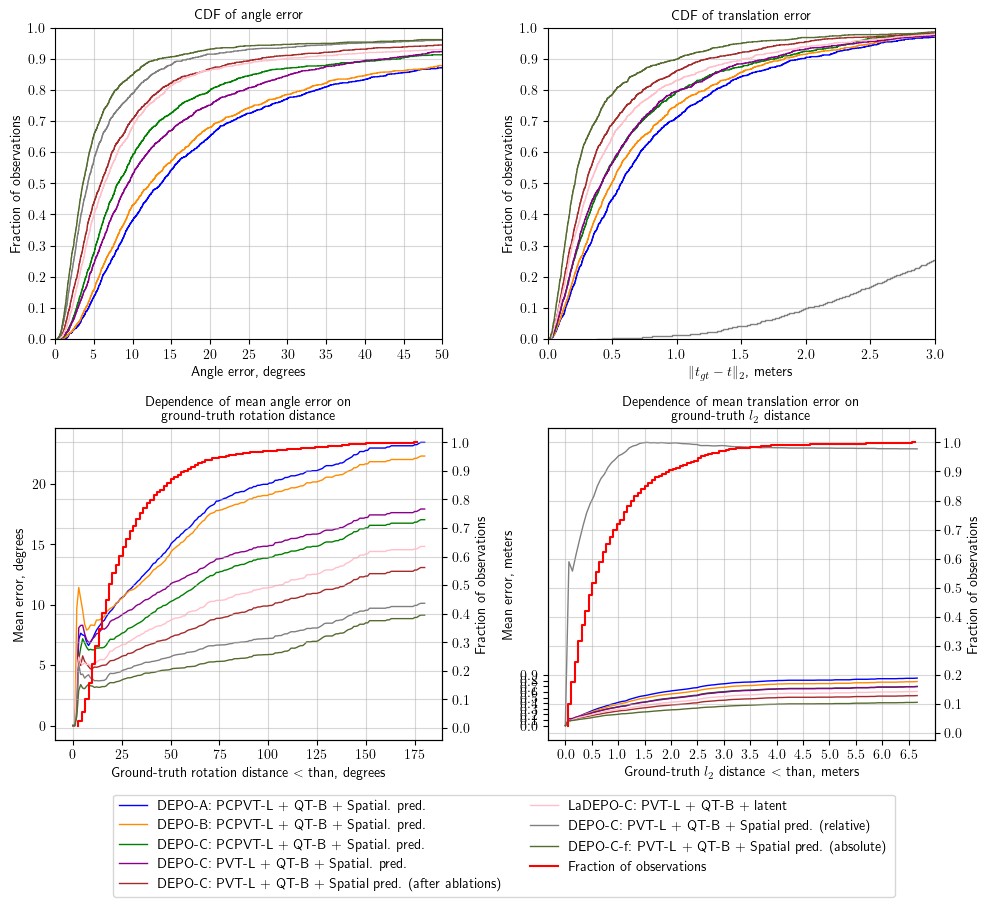

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

colors = ['b', 'darkorange' ,'g', '#8B008B',
          '#A52A2A','#FFC0CB','#808080','#556B2F','#00FFFF',
         '#FF00FF','#32CD32','#008080','#E6E6FA',
         '#D2B48C','#FA8072','#FFD700', '#000080']

exp_colors = {exp: col for  exp, col in zip(metrics.keys(), colors)}

for exp, m in metrics.items():
    sns.ecdfplot(x=m['R_angle_distances'], complementary=False, ax=ax[0,0], c=exp_colors[exp], linewidth=1)    

    sns.ecdfplot(x=m['t_distances_l2'], complementary=False, ax=ax[0,1], c=exp_colors[exp], linewidth=1, log_scale=False)

    R_on_gt = calculate_metric_on_subset(
        m['R_angle_distances'], m['R_gt_distances'], np.mean, np.linspace(0, 180, 180), '<')
    R_on_gt[np.isnan(R_on_gt)] = 0
    ax[1, 0].plot(np.linspace(0, 180, 180), R_on_gt, label=exp, c=exp_colors[exp], linewidth=1)
    
    t_on_gt = calculate_metric_on_subset(
        m['t_distances_l2'], m['t_gt_distances'], np.mean, np.linspace(0, 6.66, 100), '<')
    t_on_gt[np.isnan(t_on_gt)] = 0
    ax[1, 1].plot(np.linspace(0, 6.66, 100), t_on_gt, c=exp_colors[exp], linewidth=1)

    
    
ax[0, 0].set_xlim([0., 50.])
ax[0, 0].set_xticks(np.linspace(0, 50, 11, dtype='int'))
ax[0, 0].set_yticks(np.linspace(0, 1, 11))
ax[0, 0].set_ylabel('Fraction of observations')
ax[0, 0].set_xlabel('Angle error, degrees')
ax[0, 0].set_title('CDF of angle error')
ax[0, 0].grid(alpha=0.5)


ax[0, 1].set_xlim([0., 3.])
ax[0, 1].set_yticks(np.linspace(0, 1, 11))
ax[0, 1].set_ylabel('Fraction of observations')
ax[0, 1].set_xlabel('$\|t_{gt} - t\|_2$, meters')
ax[0, 1].set_title('CDF of translation error')
ax[0, 1].grid(alpha=0.5)


n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['R_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['R_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_10 = ax[1, 0].twinx() # create secondary axis with shared x-axis  
ax_10.step(bin_centers,cdf_values,'r', label='Fraction of observations')
ax_10.set_ylabel('Fraction of observations')
ax_10.set_yticks(np.linspace(0, 1, 11))
ax_10.grid(alpha=0.5)
ax[1, 0].set_xlabel('Ground-truth rotation distance $<$ than, degrees')
ax[1, 0].set_ylabel('Mean error, degrees')
ax[1, 0].set_title('Dependence of mean angle error on \n ground-truth rotation distance')
ax[1, 0].grid(axis='x', alpha=0.5)

n_bins = 100 # number of bins for histogram calculation 
counts, bin_edges = np.histogram(np.sort(m['t_gt_distances']), bins=n_bins)
cdf_values = np.cumsum(counts) / len(m['t_gt_distances'])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
ax_11 = ax[1, 1].twinx() # create secondary axis with shared x-axis  
ax_11.step(bin_centers, cdf_values, 'r', label='Fraction of observations')
ax_11.set_ylabel('Fraction of observations')
ax_11.set_yticks(np.linspace(0, 1, 11))
ax_11.grid(alpha=0.5)
ax[1, 1].set_xticks(np.linspace(0, 6.5, 14))
ax[1, 1].set_yticks(np.linspace(0, 0.9, 10))
ax[1, 1].set_xlabel('Ground-truth $l_2$ distance $<$ than, meters')
ax[1, 1].set_ylabel('Mean error, meters')
ax[1, 1].set_title('Dependence of mean translation error on \n ground-truth $l_2$ distance')
ax[1, 1].grid(axis='x', alpha=0.5)


handles, labels = ax[1, 0].get_legend_handles_labels()
handles.extend(ax_11.get_legend_handles_labels()[0])
labels.extend(ax_11.get_legend_handles_labels()[1])
fig.legend(handles, labels, bbox_to_anchor=(.9, 0), borderaxespad=0.0, ncol=2)
fig.tight_layout()
plt.savefig('/home/project/code/results/images/scannet_cdfs_depo.pdf', bbox_inches='tight')

# Time estimation 

In [ ]:
time_eval = []
for data in test_loader: 
    for key in data.keys():
        if key in ('image_0', 'image_1', 'K_0', 'K_1', 'flow_0to1', 'mask'):
            data[key] = data[key].to(device)   
    B = data['image_0'].size(0)
    
    start = time.time() * 1000
    flow, q, t = model(
        img_q=data['image_0'], img_s=data['image_1'],
        K_q=data['K_0'], K_s=data['K_1'],
        scales_q=0.125 * torch.ones((B, 2), device=device),
        scales_s=0.125 * torch.ones((B, 2), device=device),
        H=60, W=80)
    end = time.time() * 1000
    time_eval.append(end-start)
    
time_eval = np.array(time_eval)
print(f'Running time is {np.mean(time_eval)} ms $\pm$ {np.std(time_eval)} ms')